# Example 0.B: Dirichlet Traces
### Sam Reynolds, 2024

**NOTE:** This tutorial is a work in progress. Check back soon for updates.

This tutorial introduces the `DirchletTrace` class, which is used to define the trace of a function on a collection of edges. In practice, we can use `DirichletTrace` objects to define the Dirichlet trace $v|_{\partial K}$ of a local function $v \in V_p(K)$, or the Dirichlet trace $w|_{\partial \Omega}$ of a global function $w \in V_p(\Omega_h)$ where $\Omega_h$ is a mesh of $\Omega$.

## Table of Contents
asdf

## Introduction
Let's begin by importing the appropriate packages and defining some edges.

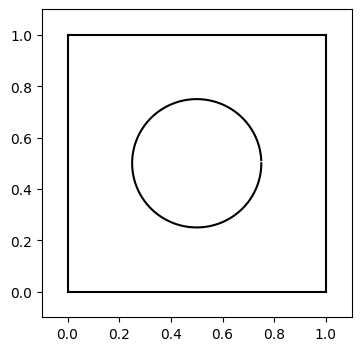

In [1]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf

# define quadrature schemes
quad_dict = pf.get_quad_dict(n=64)

# define vertices
verts: list[pf.Vert] = []
verts.append(pf.Vert(x=0.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=0.0))
verts.append(pf.Vert(x=1.0, y=1.0))
verts.append(pf.Vert(x=0.0, y=1.0))
verts.append(pf.Vert(x=0.5, y=0.5))  # center of circle

# define edges
edges: list[pf.Edge] = []
edges.append(pf.Edge(verts[0], verts[1], pos_cell_idx=0))
edges.append(pf.Edge(verts[1], verts[2], pos_cell_idx=0))
edges.append(pf.Edge(verts[2], verts[3], pos_cell_idx=0))
edges.append(pf.Edge(verts[3], verts[0], pos_cell_idx=0))
edges.append(
    pf.Edge(
        verts[4],
        verts[4],
        neg_cell_idx=0,
        curve_type="circle",
        quad_type="trap",
        radius=0.25,
    )
)

# define mesh cell
K = pf.MeshCell(idx=0, edges=edges)

# parameterize edges
K.parameterize(quad_dict)

# plot boundary
pf.plot.MeshPlot(K.get_edges()).draw()

## Declaring a `DirichletTrace` object
The `DirichletTrace` class must be initialized with the `edges` argument, which can either be:
- a list of `Edge` objects
- a `MeshCell` object
The `custom` flag indicates that we will build the trace manually, rather than using automatic methods.

**NOTE:** The automatic methods are not yet implemented.

In [2]:
# declare a Dirichlet trace with a list of edges
v_trace = pf.DirichletTrace(edges=edges, custom=True)

# which is equivalent to
v_trace = pf.DirichletTrace(edges=K, custom=True)

## Defining a trace with values
The most direct way to define a trace is to provide a list of values for the trace. This is done with the `values` argument, which can be:
- a single value, which will be applied to all edges
- a `numpy.ndarray` of values, which must have the same length as the number of sampled points
- a list of `numpy.ndarray` objects, with array $j$ corresponding to edge $j$ (and so must have the same length as the number of sampled points on that edge)
**NOTE:** The number of sampled points on each edge is $2n$, where $n$ is the sampling parameter specified in the `quad_dict`. It is *not* the number `num_pts` specified in the `Edge` object, which is $2n+1$.

In [3]:
# a constant trace
v_trace = pf.DirichletTrace(edges=K, values=1.0)

# set the trace values with a numpy.ndarray
import numpy as np

vals = np.ones((K.num_pts,))
v_trace = pf.DirichletTrace(edges=K, values=vals)

# set the trace values with a list of arrays
vals = [np.ones((e.num_pts - 1,)) for e in K.get_edges()]
v_trace = pf.DirichletTrace(edges=K, values=vals)

We can visualize the trace by passing it to the `TracePlot` class.

In [4]:
# TODO pass DirichletTrace object to plot.TracePlot

### Defining values on specific edge
Consider the local function $v \in V_p(K)$ with the trace
\begin{align*}
    v|_{\partial K} = 
    \begin{cases}
        f|_{e} &\text{on}~ e~, \\
        0 &\text{otherwise} 
    \end{cases}
\end{align*}
where $e \subset \partial K$ is an edge of the mesh cell $K$. For example, let's consider the function $f(x) = x_1(1-x_1)$ on the lower edge, which is edge $j = 0$.

In [5]:
# get the edge object e = e_j
j = 0
e = K.get_edges()[j]

# define the values of the trace f|_e on a single edge
f_e_vals = e.evaluate_function(lambda x1, x2: x1 * (1 - x1))

# alternatively, we can compute f on e_j this way:
# x1, x2 = e.get_sampled_points()
# f_e_vals = x1 * (1 - x1)

The most straightforward way to build the trace values of $v$ would be to initialize a trace with all zero values, and then modify the values on a single edge, which is what can be accomplished with the following:

In [6]:
# initialize a zero boundary trace
v_trace = pf.DirichletTrace(edges=K, values=0)

# set the values of v|_e
v_trace.set_trace_values_on_edge(edge_index=j, values=f_e_vals)

Let's see how that looks:

In [7]:
# TODO pass DirichletTrace object to plot.TracePlot

### Extracting the indices of sampled points on a specific edge
Consider a family of local functions $v_j \in V_p(K)$ with a trace defined by
\begin{align*}
    v|_{\partial K} = 
    \begin{cases}
        f|_{e_j} &\text{on}~ e_j~, \\
        0 &\text{otherwise} 
    \end{cases}
\end{align*}
where $e_j$ is edge $j$ of the mesh cell $K$.
If the function $f$ is difficult to compute, we may have precomputed the values of $f|_{\partial K}$ for the entire boundary and stored them in a `numpy.ndarray`.
For example,
\begin{align*}
    f(x) = [x_1 x_2 + (1 - x_1) (1 - x_2)] (x_1 + x_2)
\end{align*}
which we can pretend is difficult to compute.

In [8]:
f_vals = K.evaluate_function_on_boundary(
    lambda x1, x2: (x1 * x2 + (1 - x1) * (1 - x2)) * (x1 + x2)
)

We need to get the indices of the array that correspond to edge $j$, which we can do as follows:

In [9]:
j = 2
vj_trace = pf.DirichletTrace(edges=K, values=0)
start, stop = vj_trace.get_edge_sampled_point_indices(edge_index=j)

Now we are ready to set the values on edge $j$:

In [10]:
f_e_vals = f_vals[start:stop]
vj_trace.set_trace_values_on_edge(edge_index=j, values=f_e_vals)

Let's try plotting the result:

In [11]:
# TODO pass DirichletTrace object to plot.TracePlot

## Defining a trace with functions
Rather than compute the values of a function, store those values to an array, and then set the trace values as we did above, we instead have the option to assign a function $f_j:e_j\subset\mathbb{R}^2\to\mathbb{R}$ to the edge $e_j$. For example,
we might choose $f_j(x) = x_1 + j x_2$. Rather than provide a list of values/arrays to the `values` argument, we instead pass a list of functions (which must be `callable` objects with two arguments) to the `DirchletTrace` constructor via the `funcs` argument.

In [13]:
# define a different function on each edge
f_list = [lambda x1, x2: x1 + j * x2 for j in range(K.num_edges)]
v_trace = pf.DirichletTrace(edges=K, funcs=f_list)

Let's plot it:

In [18]:
# TODO pass DirichletTrace object to plot.TracePlot

If we provide just a single function, that function will be applied to all the edges:

In [15]:
# define the same function on each edge
v_trace = pf.DirichletTrace(edges=K, funcs=lambda x1, x2: x1 + x2)

Above we used the `lambda` notation to define unnamed functions, but we can also pass function handles of functions defined using `def`:

In [16]:
def f(x1, x2):
    return x1 + x2

# define a trace using a function handle
v_trace = pf.DirichletTrace(edges=K, funcs=f)

If you find yourself with a list of function handles, this list can also be passed with the `funcs` argument:

In [17]:
f_list = [f for _ in range(K.num_edges)]

# use a list of function handles
v_trace = pf.DirichletTrace(edges=K, funcs=f_list)

### Defining a trace on unparameterized edges
If the edges have been 'parameterized' (i.e. the points for evaluation have been sampled), then `DirichletTrace` will automatically evaluate the trace functions at the sampled points on their respective edges when it is initialized. 

In the event that the edges have not yet been sampled, we can still define the trace by specifying the trace function(s). 

**TODO:**
When the time comes to retrieve the trace values, `DirichletTrace` will check if the edges have parameterized, and if so, will evaluate the trace functions on their edges.

In [19]:
# TODO

 

### Defining a trace with `Polynomial` objects

### The `Func_R2_R` type


## Defining a trace of a global function 